# Turning Raw Spotify Track Data into a Modeling Dataset  
*Integration, cleaning, and feature preparation for popularity prediction*

## 1. Introduction
Music streaming has become an ordinary part of daily life, and platforms like Spotify play a central role in how listeners discover and engage with music. The listening experience today is far more personalized than it was in the past, shaped by recommendations that adapt to individual tastes, habits, and patterns over time. At the core of this transformation is data.

While listener data is not available in this project, Spotify provides extensive information at the track and artist level. This includes audio features that describe how a song sounds, metadata that situates it in time and context, and aggregate measures of engagement such as track popularity. Together, these features offer a partial but meaningful view into how songs are represented and surfaced on the platform.

This notebook focuses on preparing and integrating Spotify track and artist datasets into a clean, modeling ready format. The resulting dataset serves as the foundation for subsequent exploratory analysis and predictive modeling of song popularity.

## 2. Libraries and Setup
This section imports the core utilities used throughout the notebook and sets display options for easier inspection. The libraries cover list parsing, data manipulation, and lightweight visualization used for quick sanity checks during wrangling.

In [1]:
# Core utilities
# Purpose: Enables postponed evaluation of type annotations for cleaner type hints and forward compatibility.
from __future__ import annotations


# Abstract Syntax 
# Purpose: Used to safely convert list-like strings in the raw Spotify data into actual Python lists.
import ast


# Core data stack
# Purpose: arrays + dataframes
import pandas as pd
import numpy as np


# Visualization
# Purpose: create visualizations
import matplotlib.pyplot as plt


# Text processing
# Purpose: Text normalization
import re


# Display settings
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

## 3. Data Wrangling and Preparation

### 3.1 Read Files
The data preparation process begins by loading the raw Spotify track and artist datasets. These datasets are later combined, transformed, and feature engineered to produce an enriched, track-level dataset that is saved as a parquet file for downstream exploratory analysis and modeling.

In [2]:
tracks = pd.read_csv("tracks.csv")
artists = pd.read_csv("artists.csv")

### 3.2 Data Cleaning and Standardization

#### 3.2.1 Handling Missing Values
This section outlines the approach used to address missing values in the Spotify track and artist datasets. Handling missing data is an important part of preparing a reliable analytical dataset, as it helps ensure consistency and reduces the risk of bias or instability in downstream modeling.

In [3]:
all_dfs_dict = {"tracks": tracks,
               "artists": artists}

In [4]:
def create_null_summary(dataset_dict):
    """
    Create a dataset-level overview of size and missing values.
    """
    null_list = []
    for name, df in dataset_dict.items():
        n_rows = df.shape[0]
        n_cols = df.shape[1]
        null_sum = df.isna().any(axis=1).sum()
        total_cells = n_rows * n_cols
        # get list of column names with null values
        null_columns = df.columns[df.isnull().any()].tolist()
        # get number of columns with null values 
        n_null_columns = len(null_columns)
        # if no null columns, return an empty string
        null_columns_str = ', '.join(null_columns) if null_columns else ""
        null_list.append({
                         "dataframe":name,
                         "n_rows":n_rows,
                         "n_cols": n_cols,
                         "rows_with_nulls":null_sum,
                         "pct_rows_with_nulls": round((null_sum / n_rows * 100) if n_rows else 0, 3),
                         "columns_with_nulls":n_null_columns,
                         "null_columns_names":null_columns_str})
    return pd.DataFrame(null_list)

In [5]:
null_df = create_null_summary(all_dfs_dict).sort_values(
    by="pct_rows_with_nulls",
    ascending=False
)
null_df

,dataframe,n_rows,n_cols,rows_with_nulls,pct_rows_with_nulls,columns_with_nulls,null_columns_names
0,tracks,586672,20,71,0.012,1,name
1,artists,1162095,5,14,0.001,2,"followers, name"


In [6]:
# Drop nulls
tracks = tracks.dropna()
artists = artists.dropna()

# Sanity Check
tracks.isna().sum().sum(), artists.isna().sum().sum()

(np.int64(0), np.int64(0))

This initial overview provides a quick check of data completeness across both datasets. The number of missing values is extremely small relative to the overall size of the data, so those records are removed to keep the dataset clean. With missing values addressed, the next step focuses on reviewing and standardizing data types before continuing with further preparation.

#### 3.2.2 Data Type Standardization
This section focuses on reviewing and standardizing data types across the track and artist datasets. Ensuring that variables are stored using appropriate data types is a key step in data preparation, as it supports accurate transformations, comparisons, and downstream analysis. An initial inspection of each dataset is performed to confirm that columns align with their expected representations.

In [7]:
tracks.info()

<class 'pandas.DataFrame'>
Index: 586601 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586601 non-null  str    
 1   name              586601 non-null  str    
 2   popularity        586601 non-null  int64  
 3   duration_ms       586601 non-null  int64  
 4   explicit          586601 non-null  int64  
 5   artists           586601 non-null  str    
 6   id_artists        586601 non-null  str    
 7   release_date      586601 non-null  str    
 8   danceability      586601 non-null  float64
 9   energy            586601 non-null  float64
 10  key               586601 non-null  int64  
 11  loudness          586601 non-null  float64
 12  mode              586601 non-null  int64  
 13  speechiness       586601 non-null  float64
 14  acousticness      586601 non-null  float64
 15  instrumentalness  586601 non-null  float64
 16  liveness          586601 non-null  f

In [8]:
tracks.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [9]:
artists.info()

<class 'pandas.DataFrame'>
Index: 1162081 entries, 0 to 1162094
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1162081 non-null  str    
 1   followers   1162081 non-null  float64
 2   genres      1162081 non-null  str    
 3   name        1162081 non-null  str    
 4   popularity  1162081 non-null  int64  
dtypes: float64(1), int64(1), str(3)
memory usage: 102.3 MB


In [10]:
artists.head()

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


In [11]:
dtype_specifications = {
    "float": [
        "danceability",
        "energy",
        "loudness",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo",
        "followers"
    ],
    "int": [
        "popularity",
        "duration_ms",
        "key",
        "mode",
        "time_signature"
    ],
    "string": [
        "id",
        "name",
        "release_date" # Kept release_date as string because some entries are incomplete
    ]
}

In [12]:
def standardize_dtypes(df, spec, errors="coerce"):
    """
    Standardize dataframe dtypes based on a spec dict.
    - Preserves missing values using pandas nullable dtypes where appropriate.
    - Ignores columns not present in the dataframe.
    """
    df = df.copy()

    # dates
    for col in spec.get("datetime", []):
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors=errors)

    # floats
    for col in spec.get("float", []):
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # integers
    for col in spec.get("int", []):
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

    # strings
    for col in spec.get("string", []):
        if col in df.columns:
            df[col] = df[col].astype("string")

    # categories
    for col in spec.get("category", []):
        if col in df.columns:
            df[col] = df[col].astype("category")

    return df

In [13]:
artists = standardize_dtypes(artists, dtype_specifications)
tracks = standardize_dtypes(tracks, dtype_specifications)

In [14]:
# Extract release year for modeling
tracks["release_year"] = tracks["release_date"].str.slice(0, 4).astype("Int64")

In [15]:
# sanity check
print(artists.dtypes.sort_index())
print("-----" * 7)
print(tracks.dtypes.sort_index())

followers     float64
genres            str
id             string
name           string
popularity      Int64
dtype: object
-----------------------------------
acousticness        float64
artists                 str
danceability        float64
duration_ms           Int64
energy              float64
explicit              int64
id                   string
id_artists              str
instrumentalness    float64
key                   Int64
liveness            float64
loudness            float64
mode                  Int64
name                 string
popularity            Int64
release_date         string
release_year          Int64
speechiness         float64
tempo               float64
time_signature        Int64
valence             float64
dtype: object


Data types were standardized across numeric and string fields, and release_year was extracted from release_date for downstream feature engineering and modeling.

#### 3.2.3 Duplicate Handling
Duplicate checks are performed before parsing list-like fields to keep identifiers in a hashable format and avoid issues with row-level comparison.

In [16]:
is_duplicate_track_id = tracks.duplicated(subset="id")
print(is_duplicate_track_id.sum())

is_duplicate_artist_id = artists.duplicated(subset="id")
print(is_duplicate_artist_id.sum())

0
0


Duplicate checks were performed using the unique identifier columns for both tracks and artists. No duplicate IDs were identified at the raw dataset level, confirming that each track and artist is uniquely represented prior to downstream joins and feature aggregation.

#### 3.2.4 Handling Outliers
This section reviews potential outliers across numeric variables using a custom function that identifies extreme values on a column-level basis and summarizes them by proportion. This approach helps prioritize which variables warrant closer inspection.

In [17]:
def detect_outliers_iqr(df):
    """
    Computes the proportion of IQR-based outliers in each numeric column
    to highlight variables with heavy-tailed distributions.
    """
    rows = []

    for col in df.select_dtypes(include=["number"]).columns:
        s = df[col].dropna()
        if s.empty:
            continue

        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1

        if iqr == 0:
            outlier_count = 0
        else:
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            outlier_count = ((s < lower) | (s > upper)).sum()

        rows.append({
            "Column": col,
            "Outlier_%": outlier_count / len(s) * 100
        })

    return pd.DataFrame(rows)

In [18]:
outlier_reports = {}

outlier_reports["artists"] = detect_outliers_iqr(artists)
outlier_reports["tracks"] = detect_outliers_iqr(tracks)

combined_outliers = (
    pd.concat(outlier_reports, names=["Dataset"])
      .reset_index(level=0)
      .rename(columns={"level_0": "Dataset"})
)

# Sort
combined_outliers = combined_outliers.sort_values(
    "Outlier_%",
    ascending=False
).reset_index(drop=True)

# Stylize
styled_outliers = (
    combined_outliers.style
    .format({"Outlier_%": "{:.2f}%"})
    .background_gradient(axis=0,
                         gmap = combined_outliers["Outlier_%"],
                         cmap="YlOrRd"
                        )
)

styled_outliers

,Dataset,Column,Outlier_%
0,tracks,instrumentalness,21.92%
1,artists,followers,16.97%
2,tracks,speechiness,14.22%
3,artists,popularity,8.20%
4,tracks,liveness,6.99%
5,tracks,duration_ms,4.63%
6,tracks,loudness,2.57%
7,tracks,tempo,0.97%
8,tracks,danceability,0.32%
9,tracks,release_year,0.27%


In [19]:
artists[["followers", "popularity"]].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])

,followers,popularity
count,1.162081e+06,1162081.0
mean,1.022072e+04,8.795964
std,2.543998e+05,13.557789
min,0.000000e+00,0.0
1%,0.000000e+00,0.0
5%,0.000000e+00,0.0
50%,5.700000e+01,2.0
95%,1.051600e+04,39.0
99%,1.194922e+05,56.0
max,7.890023e+07,100.0


In [20]:
artists.sort_values("followers", ascending=False).head(10)[
    ["name", "followers", "popularity"]
]

,name,followers,popularity
144138,Ed Sheeran,78900234.0,92
144485,Ariana Grande,61301006.0,95
313676,Drake,54416812.0,98
144481,Justin Bieber,44606973.0,100
144488,Eminem,43747833.0,94
313508,Rihanna,42244011.0,92
126658,Billie Eilish,41792604.0,92
126338,Taylor Swift,38869193.0,98
126339,Imagine Dragons,33665795.0,89
144496,Queen,33483326.0,89


In [21]:
artists.sort_values("followers", ascending=True).head(10)[
    ["name", "followers", "popularity"]
]

,name,followers,popularity
0,Armid & Amir Zare Pashai feat. Sara Rouzbehani,0.0,0
642554,D Lynx,0.0,0
83795,Alex Deblanc,0.0,0
83794,jefferson luiz roecker,0.0,5
1014622,The Nix Dicksons,0.0,0
251288,"Erich Appel, Oliver Colbentson",0.0,0
1014629,Dandy Stars,0.0,0
251290,Orchestre symphonique de Munich,0.0,0
83782,Lito Jordan,0.0,8
83781,Don So Foreign,0.0,8


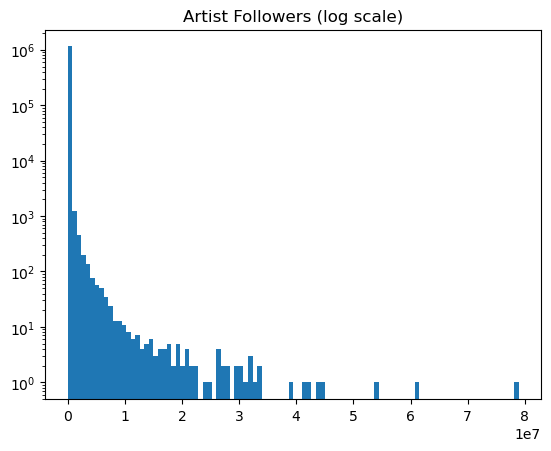

In [22]:
plt.hist(artists["followers"], bins=100)
plt.yscale("log")
plt.title("Artist Followers (log scale)")
plt.show()

Several audio features, such as instrumentalness, are known to exhibit highly skewed distributions due to the wide variety of musical styles represented in the dataset. These patterns are expected and do not necessarily indicate data quality issues, so no additional action was taken for those variables.

Artist-level metrics, including popularity and follower counts, were reviewed as a sanity check to ensure extreme values were plausible. Highly followed, well-known artists appeared at the upper end of the distribution, while lesser-known artists with zero or low follower counts appeared at the lower end, consistent with real-world expectations. As a result, no values were capped or removed during this step.

#### 3.2.5 Rename Columns
This section standardizes column names across datasets to reduce ambiguity and improve clarity prior to merging. Several fields share common names across tables, such as identifiers and popularity metrics, which can lead to confusion during joins and downstream analysis if left unchanged. Renaming these columns early helps make dataset roles explicit and ensures that merged features remain interpretable.

In [23]:
tracks.rename(columns={
    "id": "track_id",
    "name": "track_name",
    "popularity": "track_popularity",
    "id_artists": "artist_id_list"
}, 
              inplace = True)

artists.rename(columns={
    "id": "artist_id",
    "name": "artist_name",
    "popularity": "artist_popularity"
}, 
              inplace = True)

After renaming overlapping columns to clearly distinguish track-level and artist-level attributes, the datasets are better structured for subsequent merges. 

#### 3.2.6 Normalizing and Parsing List-Like Fields
Some fields in the raw data represent multi-value relationships. Before expanding the data into a track–artist format and performing merges, these fields are parsed and normalized so list-like values become consistent Python lists.

In [24]:
def parse_list_field(x, mode="generic"):
    """
    Parse list-like values and clean items based on mode.
    mode: "artists" | "artist_id" | "genres" | "generic"
    """
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return []

    if isinstance(x, np.ndarray):
        x = x.tolist()

    if isinstance(x, str):
        s = x.strip()
        if s.startswith("[") and s.endswith("]"):
            try:
                x = ast.literal_eval(s)
            except Exception:
                x = [s] if s else []
        else:
            x = [s] if s else []

    if not isinstance(x, list):
        x = [x]

    cleaned = []
    for item in x:
        if item is None:
            continue
        s = str(item).strip()

        if mode == "genres":
            s = s.lower()
        elif mode == "artist_id":
            s = s.strip("'\"")
        elif mode == "artists":
            pass

        if s:
            cleaned.append(s)

    return cleaned

In [25]:
tracks["artists"] = tracks["artists"].apply(lambda x: parse_list_field(x, "artists"))
tracks["artist_id_list"] = tracks["artist_id_list"].apply(lambda x: parse_list_field(x, "artist_id"))
artists["genres"] = artists["genres"].apply(lambda x: parse_list_field(x, "genres"))

After normalization, all list-like fields are consistent and ready for track-artist expansion.

### 3.3 Dataset Integration 
Some tracks in the dataset are associated with multiple artists, while artist-level information is stored separately. To preserve a one-track-per-row structure for modeling, the data is temporarily reshaped into a track-artist format, enriched with artist metadata, and then aggregated back to the track level. This produces a modeling dataset that keeps a 1:1 track-to-row structure while adding artist context features. The integration step also creates relative popularity features by comparing each artist’s popularity to the median artist popularity of the same release year and to the overall artist popularity median, then aggregating those values to track-level summaries.

#### 3.3.1 Expanding Tracks into a Long Track-Artist Table
Some tracks are associated with multiple artists. In this step, the data is expanded so that each row represents a single track-artist relationship. This intermediate table allows artist-level information to be joined correctly while preserving a one-track-per-row structure after aggregation.

In [26]:
track_artist_long = (
    tracks[["track_id", "release_year", "artist_id_list"]]
    .explode("artist_id_list", ignore_index=True)
    .rename(columns={"artist_id_list": "artist_id"})
)

# Composite key 
track_artist_long["track_artist_id"] = (
    track_artist_long["track_id"].astype(str) + "_" +
    track_artist_long["artist_id"].astype(str)
)

#### 3.3.2 Adding Artist Information to the Long Track-Artist Table
Artist-level attributes such as popularity, follower counts, genres, and artist names are merged into the long track-artist table created in the previous step. At this stage, the number of genres per artist is computed for later track-level aggregation. Two relative popularity features are also created at the artist-row level: one compares artist popularity to the median popularity of artists from the same release year, and the other compares artist popularity to the overall median across all years. These features are later aggregated back to one row per track.

In [27]:
# merge tracks with artist information 
track_artist_long = track_artist_long.merge(
    artists[["artist_id","artist_name","genres", "artist_popularity", "followers"]],
    on="artist_id",
    how="left"
)
track_artist_long["n_genres"] = track_artist_long["genres"].apply(
    lambda g: len(g) if isinstance(g, list) else 0
)
track_artist_long.head()

,track_id,release_year,artist_id,track_artist_id,artist_name,genres,artist_popularity,followers,n_genres
0,35iwgR4jXetI318WEWsa1Q,1922,45tIt06XoI0Iio4LBEVpls,35iwgR4jXetI318WEWsa1Q_45tIt06XoI0Iio4LBEVpls,Uli,[],4,91.0,0
1,021ht4sdgPcrDgSk7JTbKY,1922,14jtPCOoNZwquk5wd9DxrY,021ht4sdgPcrDgSk7JTbKY_14jtPCOoNZwquk5wd9DxrY,Fernando Pessoa,[],0,3.0,0
2,07A5yehtSnoedViJAZkNnc,1922,5LiOoJbxVSAMkBS2fUm3X2,07A5yehtSnoedViJAZkNnc_5LiOoJbxVSAMkBS2fUm3X2,Ignacio Corsini,"[tango, vintage tango]",23,3528.0,2
3,08FmqUhxtyLTn6pAh6bk45,1922,5LiOoJbxVSAMkBS2fUm3X2,08FmqUhxtyLTn6pAh6bk45_5LiOoJbxVSAMkBS2fUm3X2,Ignacio Corsini,"[tango, vintage tango]",23,3528.0,2
4,08y9GfoqCWfOGsKdwojr5e,1922,3BiJGZsyX9sJchTqcSA7Su,08y9GfoqCWfOGsKdwojr5e_3BiJGZsyX9sJchTqcSA7Su,Dick Haymes,"[adult standards, big band, easy listening, lo...",35,11327.0,5


In [28]:
year_artist_pop_median = track_artist_long.groupby("release_year")["artist_popularity"].median()
global_artist_pop_median = track_artist_long["artist_popularity"].median()

track_artist_long["artist_popularity_vs_year"] = (
    track_artist_long["artist_popularity"]
    - track_artist_long["release_year"].map(year_artist_pop_median)
)
track_artist_long["artist_popularity_vs_global"] = (
    track_artist_long["artist_popularity"] - global_artist_pop_median
)
track_artist_long.head()

,track_id,release_year,artist_id,track_artist_id,artist_name,genres,artist_popularity,followers,n_genres,artist_popularity_vs_year,artist_popularity_vs_global
0,35iwgR4jXetI318WEWsa1Q,1922,45tIt06XoI0Iio4LBEVpls,35iwgR4jXetI318WEWsa1Q_45tIt06XoI0Iio4LBEVpls,Uli,[],4,91.0,0,-1.0,-47.0
1,021ht4sdgPcrDgSk7JTbKY,1922,14jtPCOoNZwquk5wd9DxrY,021ht4sdgPcrDgSk7JTbKY_14jtPCOoNZwquk5wd9DxrY,Fernando Pessoa,[],0,3.0,0,-5.0,-51.0
2,07A5yehtSnoedViJAZkNnc,1922,5LiOoJbxVSAMkBS2fUm3X2,07A5yehtSnoedViJAZkNnc_5LiOoJbxVSAMkBS2fUm3X2,Ignacio Corsini,"[tango, vintage tango]",23,3528.0,2,18.0,-28.0
3,08FmqUhxtyLTn6pAh6bk45,1922,5LiOoJbxVSAMkBS2fUm3X2,08FmqUhxtyLTn6pAh6bk45_5LiOoJbxVSAMkBS2fUm3X2,Ignacio Corsini,"[tango, vintage tango]",23,3528.0,2,18.0,-28.0
4,08y9GfoqCWfOGsKdwojr5e,1922,3BiJGZsyX9sJchTqcSA7Su,08y9GfoqCWfOGsKdwojr5e_3BiJGZsyX9sJchTqcSA7Su,Dick Haymes,"[adult standards, big band, easy listening, lo...",35,11327.0,5,30.0,-16.0


#### 3.3.3 Creating Track-Level Artist Features
Artist-level information is then summarized back to the track level. This includes the number of artists on a track, aggregated artist popularity and follower metrics, relative popularity metrics compared with year-specific and global medians, and aggregated artist genres.

In [29]:
def aggregate_genres(series):
    """
    series is a column of lists (one list per artist)
    returns a deduplicated list of genres for the track
    """
    genres = set()
    for g in series:
        if isinstance(g, (list, tuple, set, np.ndarray)):
            genres.update(list(g))
    return sorted(genres)


In [30]:
artist_agg = (
    track_artist_long
    .groupby("track_id", as_index=False)
    .agg(
        artist_popularity_mean=("artist_popularity", "mean"),
        artist_popularity_max=("artist_popularity", "max"),
        artist_popularity_vs_year_mean=("artist_popularity_vs_year", "mean"),
        artist_popularity_vs_year_max=("artist_popularity_vs_year", "max"),
        artist_popularity_vs_global_mean=("artist_popularity_vs_global", "mean"),
        artist_popularity_vs_global_max=("artist_popularity_vs_global", "max"),
        artist_followers_mean=("followers", "mean"),
        artist_followers_max=("followers", "max"),
        n_artists=("artist_id", "nunique"),
        artist_genres_mean=("n_genres", "mean"),
        artist_genres_max=("n_genres", "max"),
        artist_genres=("genres", aggregate_genres),
    )
)

In [31]:
artist_agg.head()

,track_id,artist_popularity_mean,artist_popularity_max,artist_popularity_vs_year_mean,artist_popularity_vs_year_max,artist_popularity_vs_global_mean,artist_popularity_vs_global_max,artist_followers_mean,artist_followers_max,n_artists,artist_genres_mean,artist_genres_max,artist_genres
0,0004Uy71ku11n3LMpuyf59,36.0,36,-18.0,-18.0,-15.0,-15.0,5425.0,5425.0,1,1.0,1,[polish rock]
1,000CSYu4rvd8cQ7JilfxhZ,48.0,48,-4.0,-4.0,-3.0,-3.0,30176.0,30176.0,1,2.0,2,"[country quebecois, rock quebecois]"
2,000DsoWJKHdaUmhgcnpr8j,38.0,38,-14.0,-14.0,-13.0,-13.0,8623.0,8623.0,1,1.0,1,[barnmusik]
3,000G1xMMuwxNHmwVsBdtj1,73.0,73,21.0,21.0,22.0,22.0,914213.0,914213.0,1,6.0,6,"[candy pop, new wave, new wave pop, permanent ..."
4,000KblXP5csWFFFsD6smOy,44.0,44,-8.0,-8.0,-7.0,-7.0,26380.0,26380.0,1,3.0,3,"[chamame, folclore salteno, folklore argentino]"


#### 3.3.4 Creating an Enriched Tracks Dataset
The aggregated artist features are joined to the original track data to form a new, enriched tracks dataset, while preserving the original tracks table for independent analysis.

In [32]:
tracks_enriched = tracks.merge(
    artist_agg,
    on="track_id",
    how="left"
)

tracks_enriched.head()

,track_id,track_name,track_popularity,duration_ms,explicit,artists,artist_id_list,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year,artist_popularity_mean,artist_popularity_max,artist_popularity_vs_year_mean,artist_popularity_vs_year_max,artist_popularity_vs_global_mean,artist_popularity_vs_global_max,artist_followers_mean,artist_followers_max,n_artists,artist_genres_mean,artist_genres_max,artist_genres
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,[Uli],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,1922,4.0,4,-1.0,-1.0,-47.0,-47.0,91.0,91.0,1,0.0,0,[]
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,1922,0.0,0,-5.0,-5.0,-51.0,-51.0,3.0,3.0,1,0.0,0,[]
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,1922,23.0,23,18.0,18.0,-28.0,-28.0,3528.0,3528.0,1,2.0,2,"[tango, vintage tango]"
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,1922,23.0,23,18.0,18.0,-28.0,-28.0,3528.0,3528.0,1,2.0,2,"[tango, vintage tango]"
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,[Dick Haymes],[3BiJGZsyX9sJchTqcSA7Su],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,1922,35.0,35,30.0,30.0,-16.0,-16.0,11327.0,11327.0,1,5.0,5,"[adult standards, big band, easy listening, lo..."


In [33]:
tracks_enriched.isna().mean().sort_values(ascending=False)

artist_followers_max                0.017857
artist_followers_mean               0.017857
artist_popularity_vs_global_max     0.017857
artist_popularity_vs_global_mean    0.017857
artist_popularity_vs_year_max       0.017857
artist_popularity_vs_year_mean      0.017857
artist_popularity_max               0.017857
artist_popularity_mean              0.017857
track_id                            0.000000
valence                             0.000000
artist_genres_max                   0.000000
artist_genres_mean                  0.000000
n_artists                           0.000000
release_year                        0.000000
time_signature                      0.000000
tempo                               0.000000
liveness                            0.000000
track_name                          0.000000
instrumentalness                    0.000000
acousticness                        0.000000
speechiness                         0.000000
mode                                0.000000
loudness  

In [35]:
col = "artist_genres"

is_empty_list = tracks_enriched[col].apply(lambda x: isinstance(x, list) and len(x) == 0)
empty_count = is_empty_list.sum()
total_rows = len(tracks_enriched)
empty_pct = empty_count / total_rows * 100

print("Empty lists:", empty_count)
print("Total rows:", total_rows)
print(f"Percent empty: {empty_pct:.2f}%")

Empty lists: 55331
Total rows: 586601
Percent empty: 9.43%


In [36]:
# Flag rows where aggregated artist genre metadata is available
tracks_enriched["has_genre_metadata"] = tracks_enriched["artist_genres"].apply(
    lambda x: int(isinstance(x, list) and len(x) > 0)
).astype("Int64")

In [37]:
tracks_enriched["has_genre_metadata"].value_counts(dropna=False)

has_genre_metadata
1    531270
0     55331
Name: count, dtype: Int64

In [38]:
artist_agg_cols = [
    "artist_followers_mean",
    "artist_followers_max",
    "artist_popularity_mean",
    "artist_popularity_max",
    "artist_popularity_vs_global_max",
    "artist_popularity_vs_global_mean",
    "artist_popularity_vs_year_max",
    "artist_popularity_vs_year_mean"
    
]

tracks_enriched_model = tracks_enriched.dropna(subset=artist_agg_cols)

In [39]:
tracks_enriched_model.isna().mean().sort_values(ascending=False)

track_id                            0.0
artist_popularity_vs_global_mean    0.0
time_signature                      0.0
release_year                        0.0
artist_popularity_mean              0.0
artist_popularity_max               0.0
artist_popularity_vs_year_mean      0.0
artist_popularity_vs_year_max       0.0
artist_popularity_vs_global_max     0.0
track_name                          0.0
artist_followers_mean               0.0
artist_followers_max                0.0
n_artists                           0.0
artist_genres_mean                  0.0
artist_genres_max                   0.0
artist_genres                       0.0
tempo                               0.0
valence                             0.0
liveness                            0.0
instrumentalness                    0.0
acousticness                        0.0
speechiness                         0.0
mode                                0.0
loudness                            0.0
key                                 0.0


In [40]:
tracks_enriched["artist_genres"].apply(type).value_counts().head()


artist_genres
<class 'list'>    586601
Name: count, dtype: int64

In [41]:
output_path = "tracks_enriched_model.parquet"

tracks_enriched_model.to_parquet(output_path, index=False)

print(f"Enriched dataset successfully saved to '{output_path}'.")
print(f"Final shape: {tracks_enriched_model.shape}")

Enriched dataset successfully saved to 'tracks_enriched_model.parquet'.
Final shape: (576126, 34)


A small number of tracks lacked aggregated artist popularity and follower metadata. Because this represented a minimal portion of the data and was limited to artist-derived fields, these rows were excluded from the modeling dataset. In addition, some tracks contained empty aggregated genre lists. To preserve these rows while making missing genre context explicit, a binary indicator has_genre_metadata was added, where 1 denotes available genre metadata and 0 denotes an empty aggregated genre list.

## 4. Data Preparation Summary and Key Takeaways
**Summary**

This notebook focused on cleaning and preparing Spotify track and artist data for analysis. The raw data included track-level audio features, artist metadata, and list-like fields such as artist IDs and genres. To integrate artist context while preserving a one-track-per-row structure, tracks were expanded into a long track-artist format, enriched with artist information, and then aggregated back to the track level. The final dataset includes audio features, summarized artist and genre attributes, and relative artist popularity features compared to year-specific and global medians.


**Key Takeaways**
* Track and artist data exist at different levels and required reshaping to be combined correctly.
* Tracks with multiple artists were handled by expanding to a track-artist format and then aggregating artist features back to one row per track.
* List-like fields were normalized to avoid issues during merging and aggregation.
* Release year was used instead of full dates to avoid adding false precision.
* Relative popularity features were created at the artist level and aggregated to the track level.
* Missing values were minimal in the enriched tracks dataset, and about 2% of rows were removed for modeling due to missing aggregated artist metadata.
* Empty aggregated genre lists were retained and flagged using has_genre_metadata.
* The final enriched dataset is ready for downstream EDA and modeling. 